### Snapshot testing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle as Rect
import seaborn as sns
import json

from scipy.stats import mannwhitneyu

from cliffs_delta import cliffs_delta

from pathlib import Path

In [2]:
path_ss_results = Path("./results/baseline")

results = {}

for exp in path_ss_results.glob("baseline_*"):
    if "." in exp.name:
        continue
    exp_results = {}
    for run in exp.glob("*"):
        if ".csv" not in run.name:
            continue
        exp_results[run.stem] = pd.read_csv(run, index_col=0).to_dict()
    results[exp.name] = exp_results

In [3]:
(df := pd.concat({k1: pd.concat({k2: pd.DataFrame(v2) for k2, v2 in v1.items()}, axis=0) for k1, v1 in results.items()}, axis=0))

pixel_similarity  structural_similarity  \
baseline_exp_state_4  i 0          1.000000               1.000000   
                        1          0.995627               0.996699   
                        2          0.981865               0.986292   
                        3          0.980674               0.979624   
                        4          0.973200               0.974148   
...                                     ...                    ...   
baseline_exp_layout_5 h 5          0.898141               0.943859   
                        6          0.886672               0.934111   
                        7          0.894237               0.939556   
                        8          0.889673               0.936260   
                        9          0.766144               0.919147   

                           mean_squared_error  
baseline_exp_state_4  i 0            0.000000  
                        1           35.403599  
                        2          179.160780  
                        3          216.616248  
                        4          271.787284  
...                                       ...  
baseline_exp_layout_5 h 5          395.162014  
                        6          563.188739  
                        7          422.157401  
                        8          500.510863  
                        9          458.331525  

[2500 rows x 3 columns]

In [4]:
df.sort_index(inplace=True)

#### Automatically set thresholds

In [5]:
(th_pix := df.loc["baseline_exp_0", "pixel_similarity"].min())

0.8159963650173611

In [6]:
(th_mse := df.loc["baseline_exp_0", "mean_squared_error"].max())

557.7593001302083

In [7]:
(th_ssim := df.loc["baseline_exp_0", "structural_similarity"].min())

0.9360689269466528

#### Visualize

In [8]:
df_heatmap = df.stack().unstack(level=[0,1]).swaplevel(0,1)

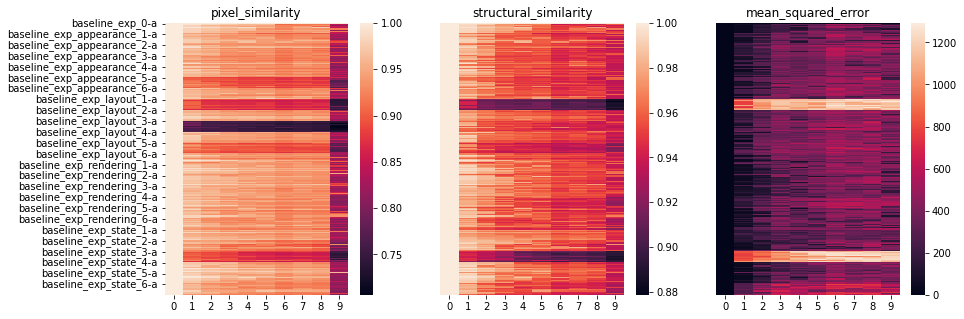

In [9]:
fig, axes = plt.subplots(1,3, figsize=(14, 5))

for i, (ax, metric) in enumerate(zip(axes, df_heatmap.index.unique(level=0))):
    sns.heatmap(df_heatmap.loc[metric].T, ax=ax)
    ax.set_title(metric)
    ax.set_ylabel("")
    if i != 0:
        ax.set_yticks([])

fig.show()

In [10]:
df_plot = df.reset_index()
df_plot.sort_values(by=["level_0", "level_1", "level_2"], inplace=True)
df_plot.rename({"level_0": "exp"}, axis=1, inplace=True)

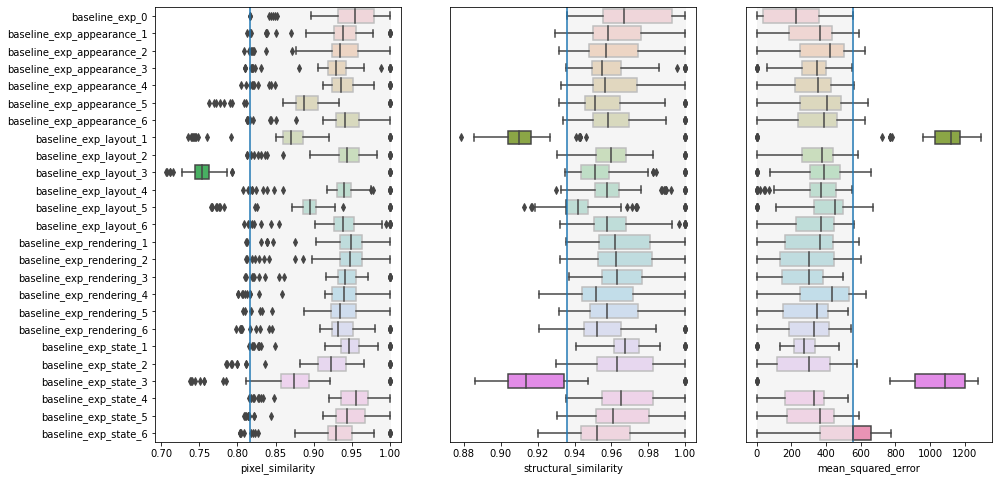

In [11]:
fig, axes = plt.subplots(1,3, figsize=(15,8))

n = df_plot["exp"].nunique()

for i, (ax, metric) in enumerate(zip(axes, df.columns)):
    sns.boxplot(data=df_plot, y="exp", x=metric, ax=ax, orient="h")
    
    if metric == "mean_squared_error":
        th = df.loc["baseline_exp_0", metric].max()
        width = -th
    else:
        th = df.loc["baseline_exp_0", metric].min()
        width = 1 - th
    
    ax.vlines(th, -0.5, df_plot["exp"].nunique()-0.5)
    ax.add_patch(Rect((th, -0.5), width=width, height=n, alpha=0.7, color=(0.95, 0.95, 0.95)))
    ax.set_ylabel("")
    
    if i !=0:
        ax.set_yticks([])
        
plt.show()

#### save for plotting in one figure with our approach
... and for mann whitney u + cliffs delta

In [12]:
df.loc["baseline_exp_0", "class"] = "okay"
df["class"].fillna("buggy", inplace=True)


df = df.reset_index().rename({
    "level_0": "exp",
    "level_1": "run",
    "level_2": "snapshot",
}, axis=1)

In [13]:
df.to_csv("./results/baseline_sims.csv")

### Mann Whitney U test

In [14]:
df_buggy = df_plot[df_plot["exp"] == "baseline_exp_0"]
df_okay = df_plot[df_plot["exp"] != "baseline_exp_0"]

metric_cols = [
    "pixel_similarity",
    "mean_squared_error",
    "structural_similarity"
]

pd.DataFrame(mannwhitneyu(df_buggy[metric_cols], df_okay[metric_cols])).T

,0,1
0,159093.0,3.193471e-08
1,77121.5,1.311139e-09
2,157976.5,7.763887e-08


### Cliff's Delta

In [15]:
effect_sizes = {}

for metric in metric_cols:
    effect_sizes[metric] = cliffs_delta(df_buggy[metric], df_okay[metric])

In [16]:
pd.DataFrame(effect_sizes).T

,0,1
pixel_similarity,0.325775,small
mean_squared_error,-0.357321,medium
structural_similarity,0.316471,small


#### bug detection

In [17]:
bd = pd.DataFrame()
bd["PCT"] = (df.groupby(["exp", "run"]).min()["pixel_similarity"] < th_pix).groupby(level=0).sum()
bd["MSE"] = (df.groupby(["exp", "run"]).max()["mean_squared_error"] > th_mse).groupby(level=0).sum()
bd["SSIM"] = (df.groupby(["exp", "run"]).min()["structural_similarity"] < th_ssim).groupby(level=0).sum()
bd.drop("baseline_exp_0", axis=0, inplace=True)

In [18]:
bd

,PCT,MSE,SSIM
exp,,,
baseline_exp_appearance_1,1,4,4
baseline_exp_appearance_2,2,7,3
baseline_exp_appearance_3,3,0,3
baseline_exp_appearance_4,3,1,4
baseline_exp_appearance_5,9,3,7
baseline_exp_appearance_6,3,3,5
baseline_exp_layout_1,10,10,10
baseline_exp_layout_2,2,2,2
baseline_exp_layout_3,10,5,3


In [19]:
num_exps = bd.index.unique(level=0).shape[0]
num_runs_per_exp =  df["run"].unique().shape[0]
bd.sum() / (num_exps * num_runs_per_exp)

PCT     0.445833
MSE     0.333333
SSIM    0.445833
dtype: float64

----